In this Jupyter Notebook, we demonstrate why the implement of Graph Locally Linear Embedding in Python Package nxt-gem[https://pypi.org/project/nxt-gem/] is not quite correct by looking at the code and an example. 

In fact, when implementing Locally Linear Embedding, the eigenvalues should be ordered; then we will take the eigenvectors corresponding to low eigenvectors. However, in next-gem, the eigenvalues were not ordered. As a result, the embedding result was not quite correct.

Furthermore, we will demonstrate the above claim with an example below. Inspired by paper "Community detection in networks using graph embeddings" by Tandon and his coauthors, we will first implement Locally Linear Embedding for the LFR benchmark graph. Then, we will do data clustering on the embedded data points with $k$-means. If the initial embedding result is correct, then, then will get a community structure similar to the ground-truth (instrinsic) community structure of the LFR benchmark graph.  

In [1]:
### Using networkx package, we generate LFR_benchmark_graph with the folllwing parameters
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 200
tau1 = 3  # Power-law exponent for the degree distribution
tau2 = 1.5 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.2 # Mixing parameter
avg_deg = 25 # Average Degree
max_deg = 60 # Max Degree
min_commu = 30 # Min Community Size
max_commu = 60 # Max Community Size


G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu, 
    seed=2
)

pos = nx.spring_layout(G)

# nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')  # Draw the graph generated above


G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

### LFR benchmark has intrinsic community structure, we get this structure and store it in a dict.
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break
# intrinsic_membership = list(intrinsic_membership.values())

# We also store the community dict in list and clustering forms.
intrinsic_list = list(intrinsic_membership.values())
from clusim.clustering import Clustering
intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})

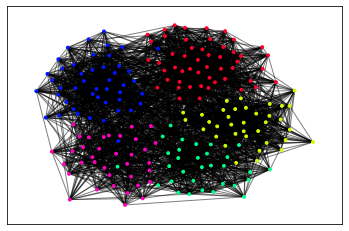

There are 5 communities in the LFR benchmark graph generated above.


In [2]:
### We plot the ground-truth community structure of the LFR benchmark graph.
import matplotlib
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      node_size=8,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=intrinsic_list
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
print(f"There are {len(set(intrinsic_list))} communities in the LFR benchmark graph generated above.")

In the following cell, we use our LLE implementation coupled with $k$-means. we use two types of $k$-means (Euclidean $k$-means and spherical $k$-means) to give two community structures.Interested readers may refer to paper "Community detection in networks using graph embeddings" by Tandon and his coauthors for details. 
After getting community structures based on LLE and $k$-means, we compare the ground-truth community structure with the two community structures we obtained based on LLE and $k$-means.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 18:39:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/03 18:39:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


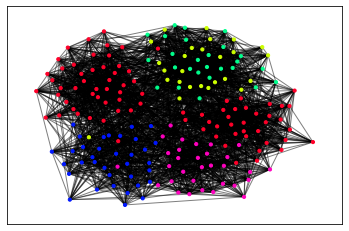

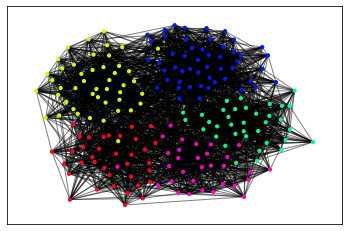

The NMI scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means: 0.837199682169491
The NMI scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means: 1.0
The ECS scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means: 0.6608755778734258
The ECS scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means: 1.0


In [3]:
### Our LLE method
from LLE_Cupy import lle_cupy as lle
D = 5 # This is the embedding dimension
lle_embd = lle(G, D)


### import my package for clustering evaluation, compared to the instrinsic community structure
from evaluate_embedding import evaluate_embedding as EE

import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                createDataFrame([(vector,) for vector in lle_vec], ["embd"])

euclid_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd")
cosine_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

nx.draw_networkx_nodes(G,
              pos,
              #louvain_membership.keys(),
              node_size=10,
              cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
              node_color=list(lle_euclid_membership)
              )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
nx.draw_networkx_nodes(G,
        pos,
        #louvain_membership.keys(),
        node_size=10,
        cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
        node_color=list(lle_cosine_membership)
        )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

print("The NMI scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[0])
print("The NMI scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[1])
print("The ECS scores between the ground-truth community strucure and the community structure by our LLE with Euclidean k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[2])
print("The ECS scores between the ground-truth community strucure and the community structure by our LLE with spherical k-means:", EE(intrinsic_list, intrinsic_clustering, lle_embd)[3])


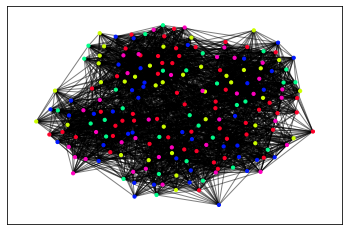

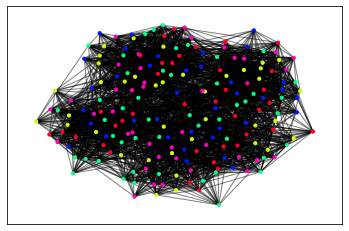

The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:
 0.015097250205506918
The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:
 0.016779177993483368
The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:
 0.19224713356744888
The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:
 0.19516921090418207


In [13]:
### Locally Linear Method from nxt-gem package
from gem.embedding.lle import LocallyLinearEmbedding


lle_model = LocallyLinearEmbedding(d=D)

lle_embd = lle_model.learn_embedding(graph=G, is_weighted=True, no_python=True)


lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                createDataFrame([(vector,) for vector in lle_vec], ["embd"])

euclid_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd")
cosine_kmeans = KMeans(k=len(set(intrinsic_list)), featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

nx.draw_networkx_nodes(G,
              pos,
              #louvain_membership.keys(),
              node_size=10,
              cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
              node_color=list(lle_euclid_membership)
              )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
nx.draw_networkx_nodes(G,
        pos,
        #louvain_membership.keys(),
        node_size=10,
        cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
        node_color=list(lle_cosine_membership)
        )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


print("The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[0])
print("The NMI scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[1])
print("The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with Euclidean k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[2])
print("The ECS scores between the ground-truth community strucure and the community structure by nxt-gem implemented LLE with spherical k-means:\n", EE(intrinsic_list, intrinsic_clustering, lle_embd)[3])